In [1]:
import numpy as np
import pandas as pd
import os
import process_data
import gmm
import datetime
import figure_functions
import run_analysis
import process_data
import kmeans_utils
import write_results

In [2]:
curr_dir = os.getcwd()
data_path = curr_dir + '/../data'
fig_path = curr_dir + '/../figs'
results_path = curr_dir + '/../results'
animation_path = curr_dir + '/../animation'
belltown_path = data_path + '/Belltown_Hour'
commcore_path = data_path + '/CommercialCore_Hour'
pikepine_path = data_path + '/PikePine_Hour'
dennytriangle_path = data_path + '/DennyTriangle_Hour'
firsthill_path = data_path + '/FirstHill_Hour'
uptown_path = data_path + '/Uptown_Hour'
uptowntriangle_path = data_path + '/UptownTriangle_Hour'
southlakeunion_path = data_path + '/SouthLakeUnion_Hour'
raw_transaction_path = data_path + '/RawTransactionData'

In [4]:
params = process_data.load_data(data_path=data_path, load_paths=[belltown_path])
element_keys, loads, gps_loc, park_data, idx_to_day_hour, day_hour_to_idx = params

In [9]:
pd.set_option('display.max_columns', None)  
df = pd.read_csv(os.path.join(data_path, 'paystation_info.csv')).head()

In [ ]:
df.loc[df['ELMNTKEY'].isin]

In [5]:
figure_functions.plot_paid_areas(element_keys, data_path, fig_path)

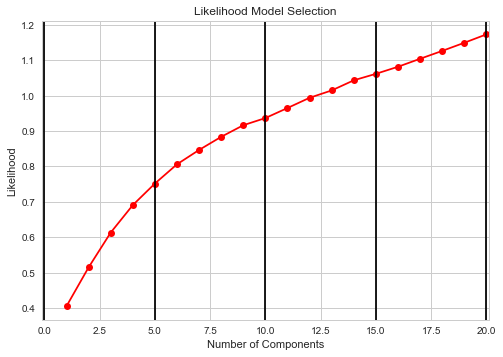

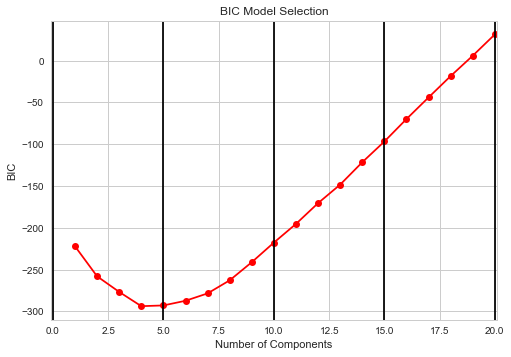

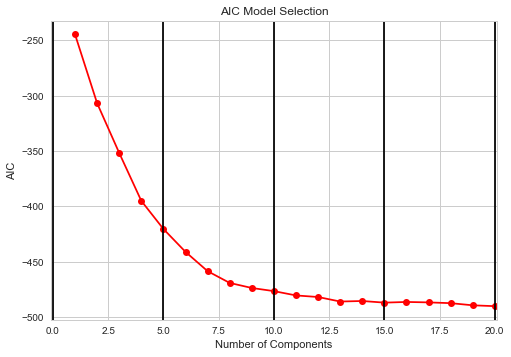

In [5]:
figure_functions.model_selection(loads=loads, gps_loc=gps_loc,
                                 fig_path=fig_path, show_fig=True)

In [10]:
num_comps = 5
k = 50
p_value = .01

In [11]:
results_path = curr_dir + '/../results_belltown_denny'

In [12]:
results = gmm.locational_demand_analysis_moran(park_data=park_data, gps_loc=gps_loc,
                                               num_comps=num_comps, k=k)

days = [result[0] for result in results]
hours = [result[1] for result in results]
morans_mixture = [result[2] for result in results]
morans_area = [result[3] for result in results]
morans_neighbor = [result[4] for result in results]
centers = [result[5] for result in results]

Starting day 0 and hour 8
Starting day 0 and hour 11
Starting day 0 and hour 14
Starting day 0 and hour 17
Starting day 1 and hour 8
Starting day 1 and hour 11
Starting day 1 and hour 14
Starting day 1 and hour 17
Finished day 0 and hour 8
Starting day 0 and hour 9
Finished day 0 and hour 11
Starting day 0 and hour 12
Finished day 0 and hour 17
Starting day 0 and hour 18
Finished day 0 and hour 14
Starting day 0 and hour 15
Finished day 1 and hour 8
Starting day 1 and hour 9
Finished day 1 and hour 11
Starting day 1 and hour 12
Finished day 1 and hour 17
Starting day 1 and hour 18
Finished day 1 and hour 14
Starting day 1 and hour 15
Finished day 0 and hour 9
Starting day 0 and hour 10
Finished day 0 and hour 15
Starting day 0 and hour 16
Finished day 0 and hour 12
Starting day 0 and hour 13
Finished day 0 and hour 18
Starting day 0 and hour 19
Finished day 1 and hour 9
Starting day 1 and hour 10
Finished day 1 and hour 15
Starting day 1 and hour 16
Finished day 1 and hour 12
Starting 

In [13]:
write_results.write_moran_results(days=days, hours=hours, morans_mixture=morans_mixture,
                                  morans_area=morans_area, morans_neighbor=morans_neighbor,
                                  p_value=p_value, results_path=results_path)

In [ ]:
fig_path = curr_dir + '/../figs1'

In [ ]:
figure_functions.plot_neighborhoods(element_keys=element_keys, data_path=data_path,
                                    fig_path=fig_path)

figure_functions.plot_paid_areas(element_keys=element_keys, data_path=data_path,
                                 fig_path=fig_path)

In [ ]:
curr_dir = os.getcwd()
data_path = curr_dir + '/../data'
fig_path = curr_dir + '/../figs1'
results_path = curr_dir + '/../results1'
animation_path = curr_dir + '/../animation'
belltown_path = data_path + '/Belltown_Hour'
commcore_path = data_path + '/CommercialCore_Hour'
pikepine_path = data_path + '/PikePine_Hour'
dennytriangle_path = data_path + '/DennyTriangle_Hour'
firsthill_path = data_path + '/FirstHill_Hour'
raw_transaction_path = data_path + '/RawTransactionData'

In [ ]:
time = 58
num_comps = 6
k = 5
p_value = .01

In [ ]:
run_analysis.run_gmm_simulations(park_data, gps_loc, time, num_comps, k, p_value, fig_path, results_path)

In [ ]:
curr_dir = os.getcwd()
data_path = curr_dir + '/../data'
fig_path = curr_dir + '/../figs2'
results_path = curr_dir + '/../results2'
animation_path = curr_dir + '/../animation'
belltown_path = data_path + '/Belltown_Hour'
commcore_path = data_path + '/CommercialCore_Hour'
pikepine_path = data_path + '/PikePine_Hour'
dennytriangle_path = data_path + '/DennyTriangle_Hour'
firsthill_path = data_path + '/FirstHill_Hour'
raw_transaction_path = data_path + '/RawTransactionData'

In [ ]:
time = 58
num_comps = 7
k = 7
p_value = .01

In [ ]:
run_analysis.run_gmm_simulations(park_data, gps_loc, time, num_comps, k, p_value, fig_path, results_path)

In [ ]:
curr_dir = os.getcwd()
data_path = curr_dir + '/../data'
fig_path = curr_dir + '/../figs3'
results_path = curr_dir + '/../results3'
animation_path = curr_dir + '/../animation'
belltown_path = data_path + '/Belltown_Hour'
commcore_path = data_path + '/CommercialCore_Hour'
pikepine_path = data_path + '/PikePine_Hour'
dennytriangle_path = data_path + '/DennyTriangle_Hour'
firsthill_path = data_path + '/FirstHill_Hour'
raw_transaction_path = data_path + '/RawTransactionData'

In [ ]:
time = 58
num_comps = 8
k = 5
p_value = .01

In [ ]:
run_analysis.run_gmm_simulations(park_data, gps_loc, time, num_comps, k, p_value, fig_path, results_path)

In [ ]:
daily_results = []
hourly_results = []
for num_comps in xrange(4, 7):
    print num_comps
    results = gmm.locational_demand_analysis_new(park_data, gps_loc, num_comps, k, verbose=False)
    consistencies = [result[2] for result in results]
    consistencies = np.array(consistencies).reshape((6, 12))
    daily = consistencies.mean(axis=1)
    hourly = consistencies.mean(axis=0)
    daily_results.append((num_comps, daily))
    hourly_results.append((num_comps, hourly))

In [ ]:
run_analysis.run_figures(element_keys=element_keys, loads=loads, gps_loc=gps_loc,
                         num_comps=num_comps, data_path=data_path, fig_path=fig_path,
                         animation_path=animation_path, time=time, show_fig=False)

run_analysis.run_gmm_simulations(park_data=park_data, gps_loc=gps_loc, time=time,
                                 num_comps=num_comps, k=k, p_value=p_value, fig_path=fig_path,
                                 results_path=results_path)